In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1. Data Processing

### 1.1 Red wine data (http://archive.ics.uci.edu/ml/datasets/Wine+Quality)

In [2]:
wine_df = pd.read_csv('./winequality-red.csv', sep=";")

In [3]:
wine_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


### 1.2 Iris data (https://archive.ics.uci.edu/ml/datasets/Iris)
First of all, we can set the column names based on iris.names. Next, there are the three labels(‘Iris-versicolor’,’Iris-setosa','Iris-virginica') in the form of string so that we have to convert them into the numeric vaules(0,1,2). Hence, we can use replace() for the labeling.

In [4]:
columns = ['sepal_length','sepal_width','petal_length','petal_width','species']

iris_df = pd.read_csv('./iris.data', names=columns)

In [5]:
iris_df = iris_df.replace(['Iris-versicolor','Iris-setosa','Iris-virginica'], [0, 1, 2])

In [6]:
iris_df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,1
1,4.9,3.0,1.4,0.2,1
2,4.7,3.2,1.3,0.2,1
3,4.6,3.1,1.5,0.2,1
4,5.0,3.6,1.4,0.2,1


## 2. Train and test data with normalization
In KNN algorithm, we use a distance function such as Euclidean distance so scaling data is needed not to weight specific variable. Now, we can use min-max normalization to scale train data. First of all, the row data are shuffled in order to eliminate the potential of biases or patterns by sample(frac=1). Next, we can split the data into train(x_train, y_train) with normalization and test(x_test, y_test) sets. to,numpy() is to convert the dataframe into the numpy array for matrix calculations. 

In [7]:
def normalize(df):
    df = (df-df.min())/(df.max()-df.min())
    return df

def SplitData(df, target):
    # Shuffling
    df = df.sample(frac=1,random_state=777)

    # Split data set into train(70%) and test(30%) sets
    num_train = int(len(df)*0.7)
    train_set = df[:num_train]
    test_set = df[num_train:]
    
    # normalization
    y_train = train_set[target].to_numpy()
    x_train = normalize(train_set.drop([target], axis=1)).to_numpy()
    y_test = test_set[target].to_numpy()
    x_test = normalize(test_set.drop([target], axis=1)).to_numpy()
    
    print(f'#total: {len(df)},  #xtrain: {x_train.shape}, #ytrain: {y_train.shape}, #xtest: {x_test.shape}, #xtest: {y_test.shape}')
    return x_train, y_train, x_test, y_test

In [8]:
d1x_train, d1y_train, d1x_test, d1y_test = SplitData(iris_df, 'species')
d2x_train, d2y_train, d2x_test, d2y_test = SplitData(wine_df, 'quality')

#total: 150,  #xtrain: (105, 4), #ytrain: (105,), #xtest: (45, 4), #xtest: (45,)
#total: 1599,  #xtrain: (1119, 11), #ytrain: (1119,), #xtest: (480, 11), #xtest: (480,)


## 3. Implementation of KNN algorithms
For our practice, I use classification for iris data and regression for wine data. In my KNN algorithms, we can choose the KNN type(‘regression’ or ‘classification’). If the regression is used, the mean in a neighbor is calculated for the prediction y. If the classification is selected, majority voting is implemented for the prediction y. Otherwise, the error message will appear.


First, we can measure distances between q and each i-th row of x by the eunclidean_distance function. Next, we can use numpy argsort() to get k shortest distances. For example, let’s have an array arr = np.array([5,3,1,2]) then arr.argsort() results in the index set [2 3 1 0] based on descending order of the values. Through arr.argsort()[:k], we can obtain k elements of the argsort() set. Finally, we can get the nearest y[neighbor_idx] by the index set D.argsort()[:k].


For regression, y_pred = np.mean(y[neighbor_idx]) is used. For classification, counts = np.bincount(y[neighbor_idx]) and y_pred = np.argmax(counts) are conducted. Hence, np.bincount() counts the frequency in the y[neighbor_idx] and np.argmax() selects an index which has maximum value of the frequency. (i.e. majority voting)


In [9]:
def euclidean_distance(q, x):
    s = 0
    for i in range(len(q)):
        s += (q[i]-x[i])**2
    return np.sqrt(s)
    
def predict_knn(q, x, y, k, knn_type):
    D = np.zeros(len(y))
    if knn_type == 'regression':
        for i in range(len(y)):
            D[i] = euclidean_distance(q, x[i,:])
            neighbor_idx = D.argsort()[:k]
        y_pred = np.mean(y[neighbor_idx])
        
    elif knn_type == 'classification':
        for i in range(len(y)):
            D[i] = euclidean_distance(q, x[i,:])
            neighbor_idx = D.argsort()[:k]
        counts = np.bincount(y[neighbor_idx])
        y_pred = np.argmax(counts)
        
    else:
        print('There does not exist the type.')
        
    return y_pred

In [10]:
y_class = np.zeros(len(d1y_test))
for i in range(len(d1y_test)):
    y_class[i] = predict_knn(d1x_test[i], d1x_train, d1y_train, 3,'classification')

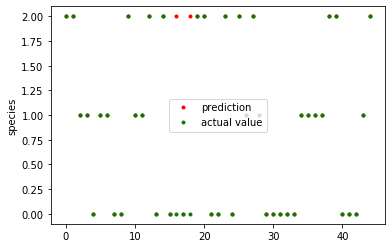

In [11]:
x1_domain = np.arange(len(y_class))
plt.plot(x1_domain, y_class, '.r')
plt.plot(x1_domain, d1y_test, '.g')
plt.ylabel('species')
plt.legend(['prediction','actual value'])

In [12]:
def accuracy(y_pred, y_actual):
    count = 0
    for i in range(len(y_pred)):
        if y_pred[i] == y_actual[i]:
            count += 1
    accuracy = count/len(y_pred)
    return round(accuracy*100,2)

print(f'Accuracy: {accuracy(y_class, d1y_test)}%')

Accuracy: 95.56%


In [13]:
y_pred = np.zeros(len(d2y_test))
for i in range(len(d2y_test)):
    y_pred[i] = predict_knn(d2x_test[i], d2x_train, d2y_train, 25,'classification')

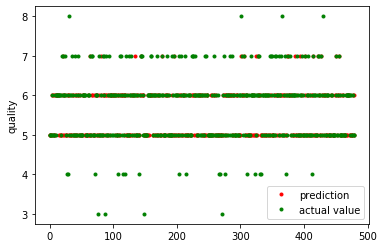

In [14]:
x2_domain = np.arange(len(y_pred))
plt.plot(x2_domain, y_pred.round(0), '.r')
plt.plot(x2_domain, d2y_test, '.g')
plt.ylabel('quality')
plt.legend(['prediction','actual value'])

In [15]:
def Loss(y_pred, y_actual):
    s = 0
    for i in range(len(y_pred)):
        s += (y_pred[i]-y_actual[i])**2
    loss = np.sqrt(s)/len(y_pred)
    return loss

print(f'Loss: {Loss(y_pred, d2y_test)}')
print(f'Accuracy: {accuracy(y_pred.round(0), d2y_test)}%')

Loss: 0.03498511588280555
Accuracy: 55.0%


## 4. Optimal Value of K in KNN algorithm

In [16]:
k_set = [1,3,5,25,100]

In [17]:
acc = []
for k in k_set:
    y_class = np.zeros(len(d1y_test))
    for i in range(len(d1y_test)):
        y_class[i] = predict_knn(d1x_test[i], d1x_train, d1y_train, k,'classification')
    acc.append(accuracy(y_class, d1y_test))  

Text(0.5, 1.0, 'Find the best k for Iris data')

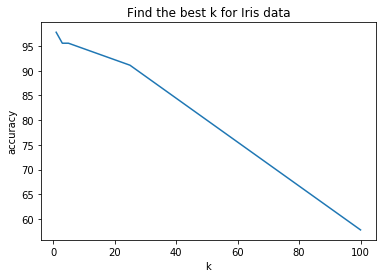

In [18]:
plt.plot(k_set,acc)
plt.xlabel('k')
plt.ylabel('accuracy')
plt.title('Find the best k for Iris data')

In [19]:
loss = []
for k in k_set:
    y_pred = np.zeros(len(d2y_test))
    for i in range(len(d2y_test)):
        y_pred[i] = predict_knn(d2x_test[i], d2x_train, d2y_train, k,'regression')
    loss.append(Loss(y_pred, d2y_test))    

Text(0.5, 1.0, 'Find the best k for Wine data')

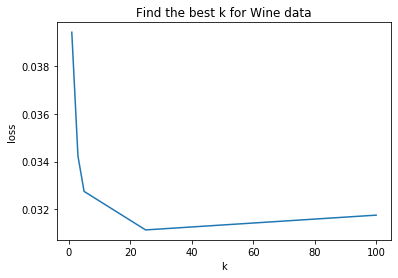

In [20]:
plt.plot(k_set,loss)
plt.xlabel('k')
plt.ylabel('loss')
plt.title('Find the best k for Wine data')

## 5. Conclusion

In KNN, the prediction performance depends on k and distance function, hence, we have to choose the optimal k by grid search or cross validation and select a suitable distance function for each data. Furthermore, KNN is easy to implement its code but calculation of distances is too expensive when data is large. 